<a href="https://colab.research.google.com/github/AndrewDrury/FakeNewsML/blob/main/MSCI446_FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSCI Project - Fake News
Written by Andrew Drury & Michael Cheng

### Imports
All imports required for the project.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.sparse import hstack
from mlxtend.preprocessing import TransactionEncoder

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1: Data Transformation

### Load data from tsv file
The tsv file contains 12,386 rows each containing a statement that has been fact checked with additional descriptive columns. A github repository was created in order to store the tsv file. The data is imported and assigned column names.

In [7]:
# Link to the raw tsv file stored in a Github repository
datasetUrl = 'https://raw.githubusercontent.com/AndrewDrury/FakeNewsML/main/factCheck.tsv'

# Load tsv file, assign column names to tsv
df = pd.read_csv(datasetUrl, delimiter='\t', engine='python', header=None, names=['id', 'label', 'statement', 'subjects', 'speaker', 'job-title', 'state', 'party-affiliation', 'barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'context'])

### Apply Text Mining Methods to prep Inputs

To predict the truthfulness of a statement, the words in the statement and context need to be extracted and transformed into a more useful form of input.

The following steps are taken to transform the statements and contexts into stems. The subjects do not need to be stemmed as they are already cleaned with only 144 possible values.

1.   All characters in the statements and contexts will be transformed to lowercase
2.   The strings will be split into tokens, each token representing a continuous sequence of letters
3.   All characters not present in the alphabet will be removed
4.   Remove common stopwords that do not provide any useful information (words like 'the', 'a')
5.   The SnowballStemmer package will be used to transform tokens into stems. SnowballStemmer is chosen over its commonly used predecessor, PorterStemmer, as it applies more agressive stemming and corrects common issues found in PorterStemmer. Stems are the roots of a word and will reduce the number of features (tokens). Many similar tokens will be reduced to their singular and common root. For example, the words 'likes', 'liked', 'liking', and 'likely' will all be reduced to their stem 'like'.

In [8]:
def getStems(column, removeUnique=False):
  # Transform all characters to lowercase
  lowerCase = column.str.lower()

  # Tokenize strings
  tokens = lowerCase.apply(word_tokenize)

  # Remove all characters not present in the alphabet
  tokens = tokens.apply(lambda words: [re.sub(r'[^a-z]+', '', token) for token in words])

  # Remove common stopwords that do not provide any useful information (words like 'the', 'a')
  stopList = stopwords.words('english')
  tokens = tokens.apply(lambda statement: [token for token in statement if token not in (stopList)])

  # Stem tokens in strings using SnowballStemmer
  stemmer = SnowballStemmer("english")
  stems = tokens.apply(lambda x: [stemmer.stem(y) for y in x])

  # # Remove all unique stems (all stems with only one occurence) if removeUniqueStems flag is true
  # if removeUnique:
  #   stemSet = {}
  #   for row in stems:
  #     for stem in row:
  #       if stem in stemSet:
  #         stemSet[stem] += 1
  #       else:
  #         stemSet[stem] = 1
  #   stems = stems.apply(lambda row: [val for val in row if stemSet[val]>1])
  stems = pd.DataFrame(val for val in stems)
  return stems

# Create stem matrix for all statements
statementStems = getStems(df['statement'])

# The contexts contained non-string NaN values, all NaN values are replaced by an empty string
contextsNoNan = df['context'].replace(np.nan,'')
# Create stem matrix for all contexts
contextStems = getStems(contextsNoNan)

# Store subjects, subjects do not need to be stemmed as they are already processed
subjects = df['subjects'].str.split(',', expand=True)

# Store the truth result labels
truthLabels = df['label']

### Create TF-IDF Matrix for Supervised Classification

To predict the truthfulness of a statement given a context and some subjects, a TF-IDF (term frequency inverse document frequency matrix) of stems will be created from the statements, contexts, and subjects.

A TF-IDF 2D matrix will be created from the inputs prepared above using SKLearn's TfidfVectorizer. Each row in the matrix created will represent a statement with a given context and subjects. The TF-IDF score is computed by multiplying the term frequency TF in the statement by the inverse document frequency IDF. The inverse document frequency is calculated by dividing the total number of statements by the number of documents that contain the given stem. The TF-IDF score is commonly used with textual data as it augments unique and relevant terms in a body of text such as a statement.

In [9]:
def tfidfMatrix(input):
  # Stems need to reform into sentences split with a space ' ' to use the TF-IDF vectorizer
  inputList = input.tolist()
  # Remove all empty strings
  inputList = [[val for val in row if val != ''] for row in inputList]
  # Create a list of strings, each string representing an entire row (needed for tfidf)
  inputList = [' '.join(val) for val in inputList]

  # Create TF-IDF Matrix of stems
  tfidfVectorizer = TfidfVectorizer()
  tfidfFinal = tfidfVectorizer.fit_transform(inputList)

  return tfidfFinal, tfidfVectorizer

# Group together statement stems, subjects, and context stems as the input for supervised learning
x_supervised = pd.concat([statementStems, subjects, contextStems], axis=1)

# Replace all 'None' values with empty string ''
x_supervised = np.asarray(x_supervised.fillna(value=''))

# Create tfidf matrix
x_supervised, x_vectorizer = tfidfMatrix(x_supervised)
# Store truth labels
y_supervised = truthLabels

print('There are %s columns in the tfidf matrix.'% len(x_vectorizer.get_feature_names_out()))

There are 9999 columns in the tfidf matrix.


### Encode Input Data for Unsupervised Learning with the Apriori Algorithm

In [10]:
# Group together statement stems, subjects, context stems, and truth labels for unsupervised learning input
x_unsupervised = pd.concat([statementStems, subjects, contextStems, truthLabels], axis=1)
# Replace all none values with an empty string
x_unsupervised = x_unsupervised.fillna(value='')
x_unsupervised_list = x_unsupervised.values.tolist()

# Transform data into encoded matrix for the apriori algorithm
encoder = TransactionEncoder()
aprioriRaw = encoder.fit(x_unsupervised_list).transform(x_unsupervised_list)

# Convert input data into dataframe
aprioriInput = pd.DataFrame(aprioriRaw, columns=encoder.columns_)

# Drop the column containing empty strings
aprioriInput.drop('', axis=1, inplace=True)

## Part 2: Data Description

Mean:  2139.3333333333335
Median:  2287.0
--------------------
 true           2063
mostly-true    2466
half-true      2638
barely-true    2108
false          2511
pants-fire     1050
Name: label, dtype: int64


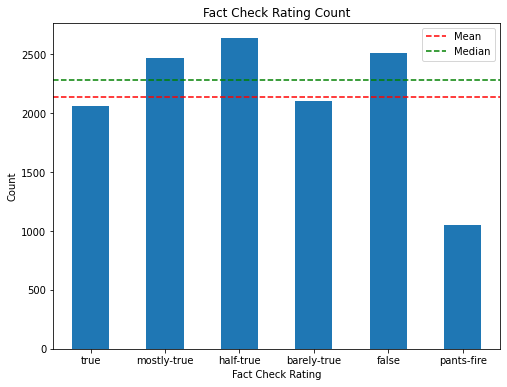

In [11]:
# Create bar chart for fact check label counts
labelCounts = y_supervised.value_counts()
labelCounts = labelCounts.reindex(['true','mostly-true','half-true','barely-true','false','pants-fire'])
labelCountPlot = labelCounts.plot(kind='bar', rot=0, title='Fact Check Rating Count', label='_nolegend_', figsize=(8,6))
# labelCountPlot.bar_label(labelCountPlot.containers[0])

labelCountPlot.set_xlabel('Fact Check Rating')
labelCountPlot.set_ylabel('Count')

mean = labelCounts.mean()
median = labelCounts.median()
labelCountPlot.axhline(mean, color='r', ls='--', label="Mean")
labelCountPlot.axhline(median, color='g', ls='--', label="Median")
labelCountPlot.legend()
print('Mean: ', mean)
print('Median: ', median)
print('-'*20+'\n', labelCounts)


## Part 3: Supervised Learning - Classification

** TO REMOVE **
If classification model performance sucks, you may want to try encoding the y variable class labels, potentialy an ordered numerical enconding since the labels are ordered themeselves from pants-on-fire fake to completely true

Another option if performance sucks would be to group the y variables class labels into 2 groups instead of the 6 ('true','mostly-true','half-true','barely-true','false','pants-fire'). So 'true' and 'mostly-true' become 'true' and everything else becomes 'false'

Also, not sure if x_supervised is formatted ideally for you, its just a 2d matrice where all values are between 0-1. To find the actual words associated with each column, you would have to trace it back.
The x matrices has 9162 statement stem columns (floats between 0-1) followed by 144 subject columns (integers 0 or 1) followed by 2104 context stem columns (term frequency integers 0, 1, or 2). So you may need to reformat it or assemble x in a different way

In [12]:
folds = 5

print(x_supervised.shape)
print(y_supervised.shape)

metrics_supervised = []

# SPLIT DATASET 80-20 TRAIN/TEST with Stratified kfold validation using 5 folds
# Stratified kfold preserves the same proportions of each class in the split
kIndices = StratifiedKFold(n_splits=folds)
for trainIndice, testIndice in kIndices.split(x_supervised, y_supervised):
  train_x, test_x = x_supervised[trainIndice], x_supervised[testIndice]
  train_y, test_y = y_supervised[trainIndice], y_supervised[testIndice]

  # Train classification model with train_x and train_y
  # Test model with test_x and test_y
  # Compute metrics for model for current kfold

# Calculate metric averages across the 5 kfolds


(12836, 9999)
(12836,)


## Part 4: Unsupervised Learning - Association Rule Mining

In [15]:
from mlxtend.preprocessing import TransactionEncoder

frequent_itemsets = apriori(aprioriInput,min_support=0.02,use_colnames=True)
print(frequent_itemsets)
rules = association_rules(frequent_itemsets,metric='confidence',min_threshold=0.01)
print(rules[['antecedents','consequents','support','confidence']])

      support                     itemsets
0    0.024696                   (abortion)
1    0.093721                         (ad)
2    0.021892                    (america)
3    0.043549                   (american)
4    0.035837                     (barack)
..        ...                          ...
204  0.026800                (true, state)
205  0.027734                (unit, state)
206  0.071673                 (taxes, tax)
207  0.035213  (health, care, health-care)
208  0.020801            (taxes, say, tax)

[209 rows x 2 columns]
       antecedents    consequents   support  confidence
0             (ad)  (barely-true)  0.022671    0.241895
1    (barely-true)           (ad)  0.022671    0.138046
2             (ad)     (campaign)  0.022593    0.241064
3       (campaign)           (ad)  0.022593    0.244726
4             (ad)    (half-true)  0.023138    0.246883
..             ...            ...       ...         ...
137   (taxes, tax)          (say)  0.020801    0.290217
138     (say